**Name: Venkata Sai Pallavi Pallapolu**

**Course number: High Performance Computing HDS5230-07**

**Assignment number: Week 05**

In [74]:
import dask
import dask.dataframe as dd
import pandas as pd
import numpy as np
import dask.array as da

**2. Extract the .csv file from the zipped archive, and load it into a Dask dataframe.**

In [75]:
df = dd.read_csv("timeseries.csv", dtype={'name':str,'level':str,'city':object,'county':str,'state':str,'country':str,'population':np.float64,'lat':float,'long':float,'url':str,'aggregate':object,'tz':str,'cases':np.float64,'deaths':np.float64,'recovered':np.float64,'active':np.float64,'tested':np.float64,'hospitalized':np.float64,'hospitalized_current':np.float64,'discharged':np.float64,'icu':np.float64,'icu_current':np.float64,'growthFactor':np.float64,'date':object})
df.head()

,locationID,slug,name,level,city,county,state,country,lat,long,...,deaths,recovered,active,tested,hospitalized,hospitalized_current,discharged,icu,icu_current,date
0,iso1:ad,ad,Andorra,country,NaN,NaN,NaN,Andorra,42.55,1.58,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-01-22
1,iso1:ad,ad,Andorra,country,NaN,NaN,NaN,Andorra,42.55,1.58,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-01-23
2,iso1:ad,ad,Andorra,country,NaN,NaN,NaN,Andorra,42.55,1.58,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-01-24
3,iso1:ad,ad,Andorra,country,NaN,NaN,NaN,Andorra,42.55,1.58,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-01-25
4,iso1:ad,ad,Andorra,country,NaN,NaN,NaN,Andorra,42.55,1.58,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-01-26


**3.1 Create a new dataframe object that consists of samples (i.e., rows) corresponding to states in the US.**

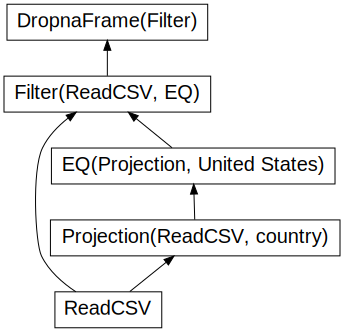

In [76]:
filtered_df = df[df["country"] == "United States"] #Filter the country U.S.
filtered_df = filtered_df.dropna(subset=['deaths', 'date', 'population', 'recovered', 'state']) #Cleaning the subset of the useful data 
filtered_df.visualize()

**3.2 During the time period 2020-Jan-01 to 2021-Feb-28, rank states in terms of their per-capita mortality? Compute per-capita mortality during a specific period as the ratio of total deaths during that time period, to the average population of the state (compute the average population during the time period).**

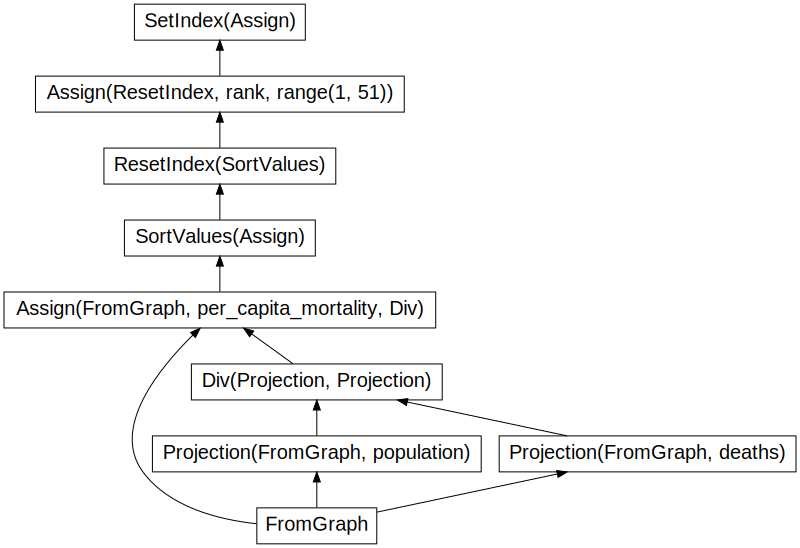

In [77]:
df_filtered = filtered_df[(filtered_df['date'] >= '2020-01-01') & (filtered_df['date'] <= '2021-02-28')] #Filter the time period of dates
state_stats = df_filtered.groupby('state').agg({'deaths': 'sum', 'population': 'mean'}).persist() #Calculating the per-capita-mortality rate
state_stats['per_capita_mortality'] = state_stats['deaths'] / state_stats['population'] 
state_mort = state_stats.sort_values(by='per_capita_mortality', ascending=False).reset_index()
state_mort['rank'] = range(1, len(state_mort) + 1) #Calculating the rank and creating a column
state_mort = state_mort.set_index('rank')
state_mort.visualize()

**3.3 During the same time period, compute the case fatality rate (CFR) per month, using one of the approaches defined in this scientific brief from the World Health Organization: https://www.who.int/news-room/commentaries/detail/estimating-mortality-from-covid-19Links to an external site. This computation should yield an array of dimensions 50 (states) X 14 (months). State the assumptions you are making in computing this metric.**

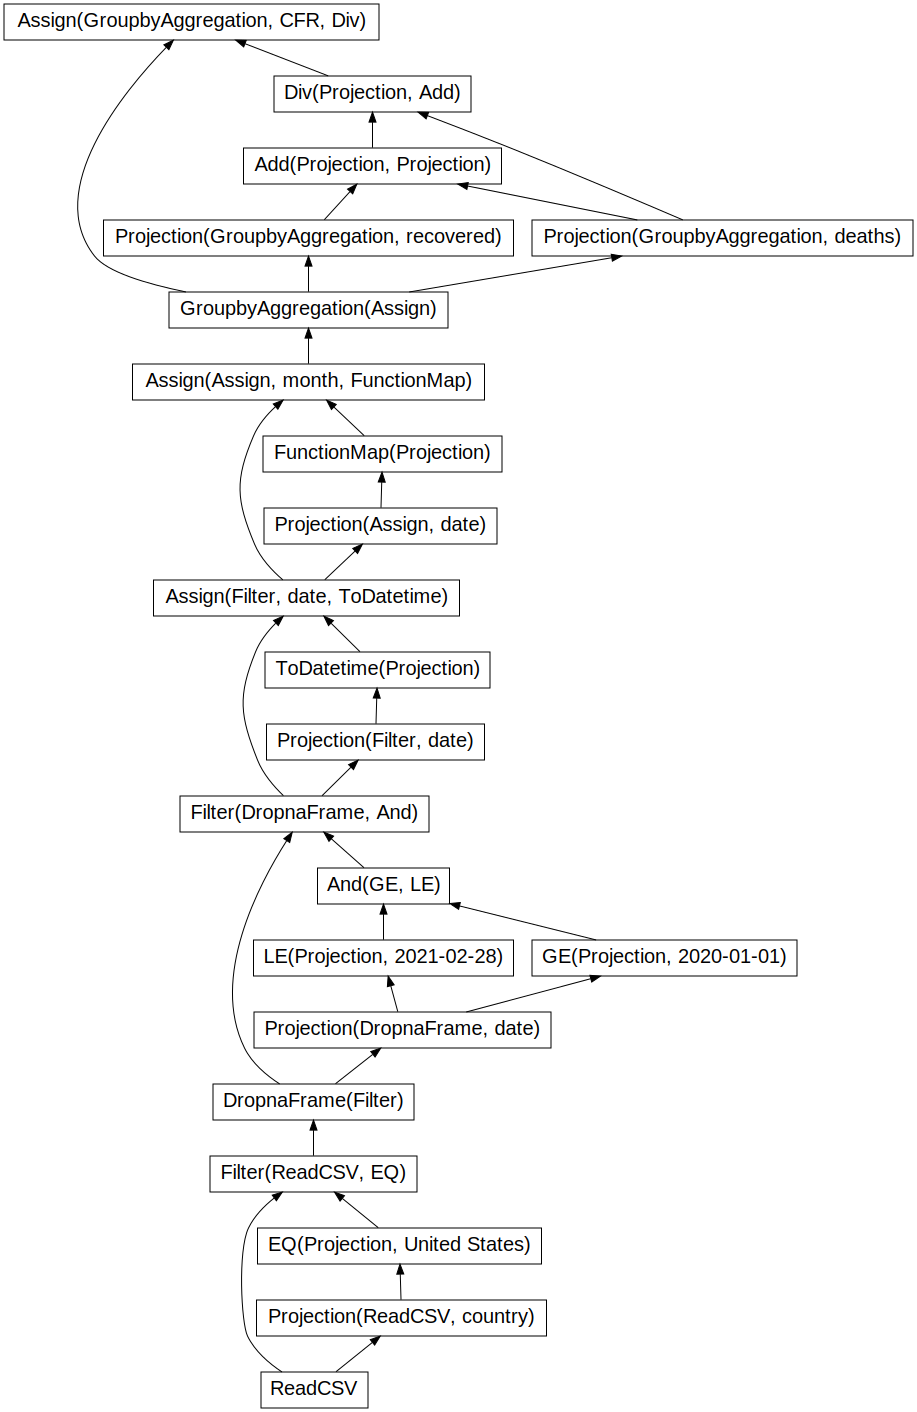

In [81]:
#I'm following approach 2
df_filtered = filtered_df[(filtered_df['date'] >= '2020-01-01') & (filtered_df['date'] <= '2021-02-28')]
df_filtered['date'] = dd.to_datetime(df_filtered['date'])
df_filtered = df_filtered.assign(month=df_filtered['date'].dt.strftime('%Y-%m'))
cfr = df_filtered.groupby(['state', 'month']).agg({'deaths': 'sum','recovered': 'sum'})
cfr = cfr.assign(CFR=cfr['deaths'] / (cfr['deaths'] + cfr['recovered']))
cfr.visualize()

In [82]:
cfr_pivot = cfr.compute().reset_index().pivot(index='state', columns='month', values='CFR')
cfr_da_array = da.from_array(cfr_pivot.to_numpy(), chunks=(10, 5))
cfr_da_array

dask.array<array, shape=(50, 8), dtype=float64, chunksize=(10, 5), chunktype=numpy.ndarray>

**Interpretation:** I have used assumption 2 because if active cases are included, some may later result in deaths, leading to underestimation of CFR. Deaths are often reported with a delay, making CFR calculations unreliable if based only on newly reported cases and deaths.

**3.4 Using this matrix as input, compute the ranking of states, on how the CFR rate changed over time. This computation will involve an aggregation of of month-to-month changes in CFR. Note that some of these month-to-month changes can be positive (CFR increases from a previous month to the current month) or negative (CFR decrease from a previous month to the current month), or zero (no change in CFR). You need to aggregate these individual changes, across all time periods.**

In [86]:
cfr_changes = da.diff(cfr_da_array, axis=1)
total_cfr_change = da.nansum(cfr_changes, axis=1)
state_cfr_ranks = pd.DataFrame({'state': cfr_pivot.index, 'total_cfr_change': total_cfr_change.compute()})
state_cfr_ranks['rank'] = state_cfr_ranks['total_cfr_change'].rank(ascending=False, method='min')
state_cfr_ranks = state_cfr_ranks.set_index('rank').sort_index()
state_cfr_ranks

,state,total_cfr_change
rank,,
1.0,Nebraska,0.978725
2.0,Delaware,0.553571
3.0,Rhode Island,0.142779
4.0,Maryland,0.062970
5.0,New York,0.030420
6.0,Wyoming,0.012221
7.0,Hawaii,0.007485
8.0,Colorado,0.004010
9.0,South Carolina,0.003400


**4. For each of the above operations, explain using appropriate reasoning, whether using a parallelized and/or distributed way of performing the computation makes sense.**

**Step-1: Loading data:** When reading large CSV files, Dask automatically chunks the data into smaller partitions and loads them in parallel using multiple CPU cores. This makes loading much faster than Pandas, which loads the entire dataset into memory sequentially. Since CSVs are row-based, they can be efficiently split and processed in parallel. If the dataset is massive with size in terabytes or if each file is too large to fit in memory on a single machine, then dask.distributed should be chosen.

**Step-2: Filtering rows corresponding to states in the US and computing per-capita-mortality rate:** This operation requires grouping by state and computing sums/averages. Aggregation functions (like sum and mean) are highly parallelizable because computations on one state do not depend on another. Dask can efficiently distribute this operation across multiple CPU cores, significantly improving performance. Since the dataset is structured as a dataframe, parallelizing filtering operations avoids unnecessary data movement. If the dataset is massive (terabytes in size), then distributed computing across multiple machines might be helpful.

**Step-3: CFR calculations per state and per month:** This operation is also independent, making it perfect for parallelization. Dask can distribute these calculations across CPU cores efficiently. Only state-level monthly aggregation is required here, hence, parallelization on a single machine should suffice.

**Step-4: Computing and ranking based on their month-to-month CFR change:** It is a simple subtraction operation but needs to be done across all states. Since each state’s changes are independent of others, this can be parallelized across CPU cores. Since we're only dealing with 50 states, even with 8 months of data, the computational burden is not large. A single machine with parallel execution should be sufficient.